In [ ]:
!wget https://storage.googleapis.com/tl_in_action/ch02/ch02_hurricane.zip

--2020-09-26 02:49:07--  https://storage.googleapis.com/tl_in_action/ch02/ch02_hurricane.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39723119 (38M) [application/x-zip-compressed]
Saving to: ‘ch02_hurricane.zip’

ch02_hurricane.zip  100%[===================>]  37.88M  87.8MB/s    in 0.4s    

2020-09-26 02:49:08 (87.8 MB/s) - ‘ch02_hurricane.zip’ saved [39723119/39723119]



In [ ]:
!unzip -q ch02_hurricane.zip

In [ ]:
!mkdir train_hurricane
!mkdir test_hurricane

In [ ]:
!mkdir train_hurricane/damage
!mkdir train_hurricane/no_damage
!mkdir test_hurricane/damage
!mkdir test_hurricane/no_damage

In [ ]:
ls -l

total 39632
-rw-r--r-- 1 root root 39723119 Sep 26 01:32 ch02_hurricane.zip
drwxr-xr-x 2 root root   417792 Sep 25 06:26 damage/
drwxr-xr-x 2 root root   425984 Sep 25 06:28 no_damage/
drwxr-xr-x 1 root root     4096 Sep 16 16:29 sample_data/
drwxr-xr-x 4 root root     4096 Sep 26 02:49 test_hurricane/
drwxr-xr-x 4 root root     4096 Sep 26 02:49 train_hurricane/


In [ ]:
from glob import glob

dmg_imgs = glob('./damage/*.jpeg')
no_dmg_imgs = glob('./no_damage/*.jpeg')
len(dmg_imgs), len(no_dmg_imgs)

(6550, 7036)

In [ ]:
from sklearn.model_selection import train_test_split

dmg_train, dmg_test = train_test_split(dmg_imgs, test_size=0.9,
                                       random_state=42)
no_dmg_train, no_dmg_test = train_test_split(no_dmg_imgs,
                                             test_size=0.9,
                                             random_state=42)

In [ ]:
len(dmg_train), len(dmg_test), len(no_dmg_train), len(no_dmg_test)

(655, 5895, 703, 6333)

In [ ]:
dmg_train[:5]

['./damage/-96.970845_28.48473.jpeg',
 './damage/-95.531816_29.746516999999997.jpeg',
 './damage/-96.90487900000001_28.783659000000004.jpeg',
 './damage/-95.081818_29.878004999999998.jpeg',
 './damage/-95.63310899999999_29.843749.jpeg']

In [ ]:
import os
from tqdm import tqdm

TRAIN_DMG_PATH = './train_hurricane/damage/'
TRAIN_NODMG_PATH = './train_hurricane/no_damage/'

TEST_DMG_PATH = './test_hurricane/damage/'
TEST_NODMG_PATH = './test_hurricane/no_damage/'

for path in tqdm(dmg_train, 
                 desc='Creating Train Dataset (dmg)'):
    fn = path.split('/')[-1]
    os.rename(path, TRAIN_DMG_PATH+fn)

for path in tqdm(no_dmg_train, 
                 desc='Creating Train Dataset (no_dmg)'):
    fn = path.split('/')[-1]
    os.rename(path, TRAIN_NODMG_PATH+fn)

for path in tqdm(dmg_test, 
                 desc='Creating Test Dataset (dmg)'):
    fn = path.split('/')[-1]
    os.rename(path, TEST_DMG_PATH+fn)

for path in tqdm(no_dmg_test, 
                 desc='Creating Test Dataset (no_dmg)'):
    fn = path.split('/')[-1]
    os.rename(path, TEST_NODMG_PATH+fn)

Creating Test Dataset (no_dmg): 100%|██████████| 6333/6333 [00:00<00:00, 42640.72it/s]


In [ ]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (1,002 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 144676 files and directories currently insta

In [ ]:
!tree --dirsfirst --filelimit 2 ./train_hurricane/

./train_hurricane/
├── damage [655 entries exceeds filelimit, not opening dir]
└── no_damage [703 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [ ]:
!tree --dirsfirst --filelimit 2 ./test_hurricane/

./test_hurricane/
├── damage [5895 entries exceeds filelimit, not opening dir]
└── no_damage [6333 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [ ]:
!rmdir damage
!rmdir no_damage

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.3.0


In [ ]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']


def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

In [ ]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


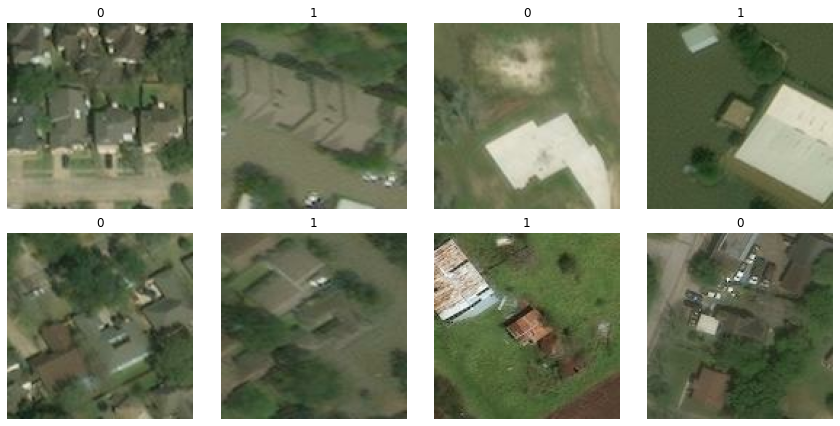

In [ ]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

In [ ]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=1, 
                  padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, 
                  padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

simple_cnn = tf.keras.Model(inputs, outputs)
simple_cnn.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)            

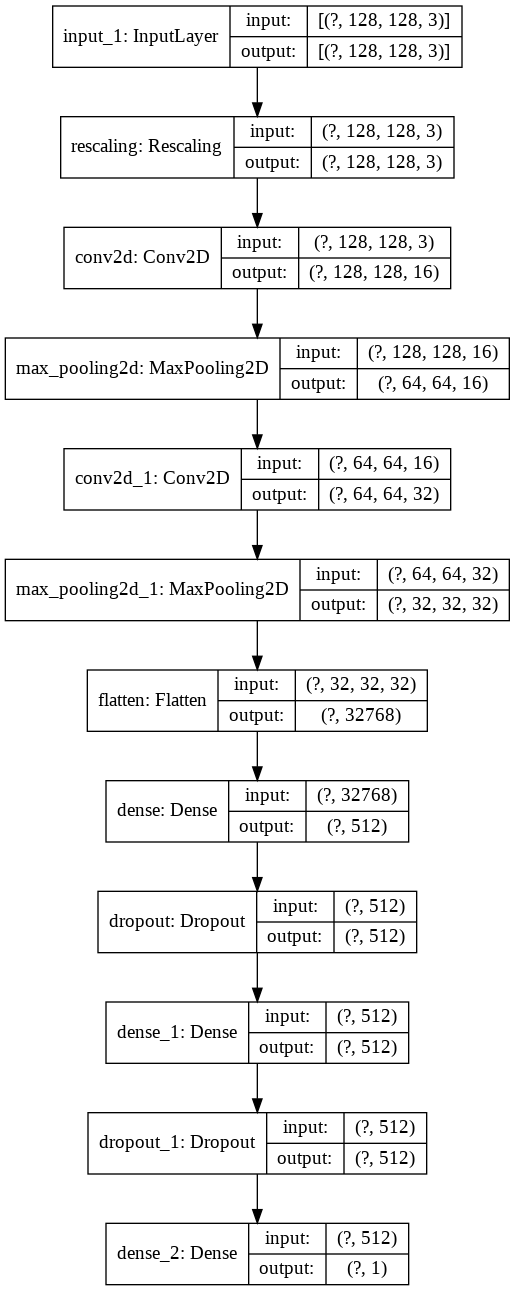

In [ ]:
tf.keras.utils.plot_model(simple_cnn, show_shapes=True)

In [ ]:
epochs = 100

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                     patience=5, 
                                     restore_best_weights=True)
]

simple_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history = simple_cnn.fit(
    train_ds, epochs=epochs, 
    callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
34/34 [==============================] - 1s 21ms/step - loss: 0.9178 - accuracy: 0.5363 - val_loss: 0.6849 - val_accuracy: 0.4945
Epoch 2/100
34/34 [==============================] - 1s 26ms/step - loss: 0.6449 - accuracy: 0.6044 - val_loss: 0.6357 - val_accuracy: 0.6015
Epoch 3/100
34/34 [==============================] - 1s 26ms/step - loss: 0.4937 - accuracy: 0.8040 - val_loss: 0.5488 - val_accuracy: 0.7380
Epoch 4/100
34/34 [==============================] - 1s 24ms/step - loss: 0.4124 - accuracy: 0.8344 - val_loss: 0.6205 - val_accuracy: 0.7159
Epoch 5/100
34/34 [==============================] - 1s 25ms/step - loss: 0.2822 - accuracy: 0.8905 - val_loss: 0.4951 - val_accuracy: 0.8229
Epoch 6/100
34/34 [==============================] - 1s 25ms/step - loss: 0.1917 - accuracy: 0.9273 - val_loss: 0.4911 - val_accuracy: 0.7860
Epoch 7/100
34/34 [==============================] - 1s 24ms/step - loss: 0.1315 - accuracy: 0.9568 - val_loss: 0.6193 - val_accuracy: 0.8118
Epoch 

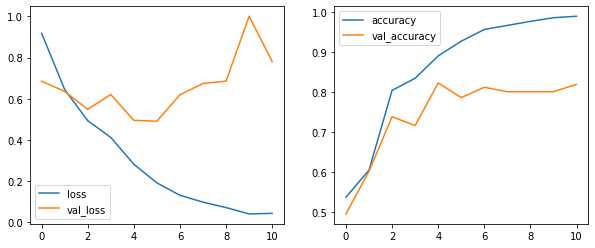

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', 
                                              ax=ax[1]);

In [ ]:
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), 
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

In [ ]:
y_true, y_pred = eval_model_on_test(simple_cnn)

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:13<00:00,  6.94it/s]


In [ ]:
y_pred[:5]

array([0.16618197, 0.98137337, 0.01400878, 0.9563993 , 0.41896623],
      dtype=float32)

In [ ]:
predicted_labels = np.array([1 if p > 0.5 else 0 
                                 for p in y_pred])
predicted_labels[:5]

array([0, 1, 0, 1, 0])

In [ ]:
classes = ['no_damage', 'damage']

print(classification_report(y_true, predicted_labels, 
                            target_names=classes))
pd.DataFrame(confusion_matrix(y_true, predicted_labels), 
             index=classes, columns=classes)

              precision    recall  f1-score   support

   no_damage       0.84      0.84      0.84      6333
      damage       0.83      0.83      0.83      5895

    accuracy                           0.84     12228
   macro avg       0.84      0.84      0.84     12228
weighted avg       0.84      0.84      0.84     12228



,no_damage,damage
no_damage,5348,985
damage,1002,4893


In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.\
            RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.\
           RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.\
            RandomZoom(height_factor=(0.1,0.3),
                       width_factor=(0.1,0.3))
    ]
)

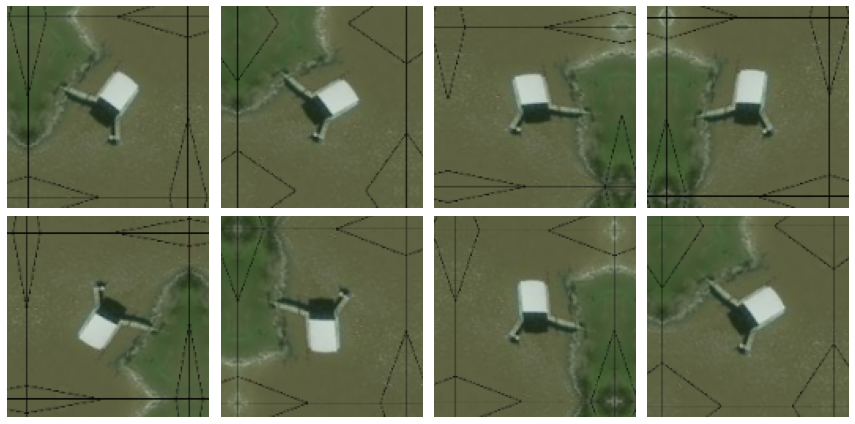

In [ ]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.tight_layout()

In [ ]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)

x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=1, 
                  padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, 
                  padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

aug_cnn = tf.keras.Model(inputs, outputs)
aug_cnn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)       

In [ ]:
epochs = 100

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                     patience=5, 
                                     restore_best_weights=True)
]

aug_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history = aug_cnn.fit(
    train_ds, epochs=epochs, 
    callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
34/34 [==============================] - 1s 28ms/step - loss: 0.7061 - accuracy: 0.4959 - val_loss: 0.6877 - val_accuracy: 0.4945
Epoch 2/100
34/34 [==============================] - 1s 26ms/step - loss: 0.6774 - accuracy: 0.5474 - val_loss: 0.6718 - val_accuracy: 0.4945
Epoch 3/100
34/34 [==============================] - 1s 27ms/step - loss: 0.6576 - accuracy: 0.6072 - val_loss: 0.6331 - val_accuracy: 0.6974
Epoch 4/100
34/34 [==============================] - 1s 25ms/step - loss: 0.6136 - accuracy: 0.7056 - val_loss: 0.5720 - val_accuracy: 0.7565
Epoch 5/100
34/34 [==============================] - 1s 24ms/step - loss: 0.5863 - accuracy: 0.7084 - val_loss: 0.5744 - val_accuracy: 0.6937
Epoch 6/100
34/34 [==============================] - 1s 27ms/step - loss: 0.5513 - accuracy: 0.7452 - val_loss: 0.5586 - val_accuracy: 0.6974
Epoch 7/100
34/34 [==============================] - 1s 27ms/step - loss: 0.5114 - accuracy: 0.7856 - val_loss: 0.5014 - val_accuracy: 0.7934
Epoch 

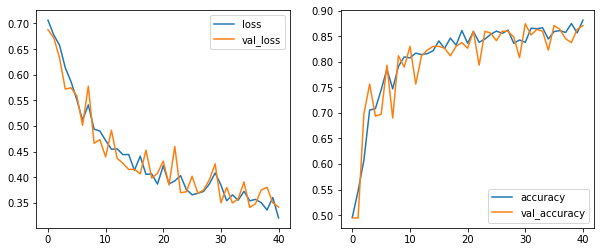

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [ ]:
y_true, y_pred = eval_model_on_test(aug_cnn)
predicted_labels = np.array([1 if p > 0.5 else 0 for p in y_pred])

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:13<00:00,  7.08it/s]


In [ ]:
print(classification_report(y_true, predicted_labels, 
                            target_names=classes))
pd.DataFrame(confusion_matrix(y_true, predicted_labels), 
             index=classes, columns=classes)

              precision    recall  f1-score   support

   no_damage       0.86      0.88      0.87      6333
      damage       0.87      0.84      0.86      5895

    accuracy                           0.86     12228
   macro avg       0.86      0.86      0.86     12228
weighted avg       0.86      0.86      0.86     12228



,no_damage,damage
no_damage,5574,759
damage,919,4976


In [ ]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


In [ ]:
base_resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=IMG_SHAPE,
    weights=None
)

base_resnet50.trainable = True

In [ ]:
base_resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
base_resnet50.trainable

True

In [ ]:
for layer in base_resnet50.layers:
    print(layer.name, '->', layer.trainable)

input_3 -> True
conv1_pad -> True
conv1_conv -> True
conv1_bn -> True
conv1_relu -> True
pool1_pad -> True
pool1_pool -> True
conv2_block1_1_conv -> True
conv2_block1_1_bn -> True
conv2_block1_1_relu -> True
conv2_block1_2_conv -> True
conv2_block1_2_bn -> True
conv2_block1_2_relu -> True
conv2_block1_0_conv -> True
conv2_block1_3_conv -> True
conv2_block1_0_bn -> True
conv2_block1_3_bn -> True
conv2_block1_add -> True
conv2_block1_out -> True
conv2_block2_1_conv -> True
conv2_block2_1_bn -> True
conv2_block2_1_relu -> True
conv2_block2_2_conv -> True
conv2_block2_2_bn -> True
conv2_block2_2_relu -> True
conv2_block2_3_conv -> True
conv2_block2_3_bn -> True
conv2_block2_add -> True
conv2_block2_out -> True
conv2_block3_1_conv -> True
conv2_block3_1_bn -> True
conv2_block3_1_relu -> True
conv2_block3_2_conv -> True
conv2_block3_2_bn -> True
conv2_block3_2_relu -> True
conv2_block3_3_conv -> True
conv2_block3_3_bn -> True
conv2_block3_add -> True
conv2_block3_out -> True
conv3_block1_1_c

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)

x = tf.keras.applications.resnet.preprocess_input(x)

x = base_resnet50(x, training=True)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

scratch_resnet50 = tf.keras.Model(inputs, outputs)
scratch_resnet50.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)              

In [ ]:
for layer in scratch_resnet50.layers:
        print(layer.name, '->', layer.trainable)

input_4 -> True
sequential -> True
tf_op_layer_strided_slice -> True
tf_op_layer_BiasAdd -> True
resnet50 -> True
global_average_pooling2d -> True
dense_6 -> True
dropout_4 -> True
dense_7 -> True
dropout_5 -> True
dense_8 -> True


In [ ]:
epochs = 100

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                     patience=5, 
                                     restore_best_weights=True)
]

scratch_resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history = scratch_resnet50.fit(
    train_ds, epochs=epochs, 
    callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
34/34 [==============================] - 4s 104ms/step - loss: 0.8250 - accuracy: 0.6173 - val_loss: 0.5314 - val_accuracy: 0.7601
Epoch 2/100
34/34 [==============================] - 2s 66ms/step - loss: 0.5682 - accuracy: 0.7360 - val_loss: 0.3954 - val_accuracy: 0.8044
Epoch 3/100
34/34 [==============================] - 2s 64ms/step - loss: 0.4988 - accuracy: 0.7884 - val_loss: 0.3271 - val_accuracy: 0.8487
Epoch 4/100
34/34 [==============================] - 2s 63ms/step - loss: 0.4127 - accuracy: 0.8353 - val_loss: 0.2975 - val_accuracy: 0.8635
Epoch 5/100
34/34 [==============================] - 2s 58ms/step - loss: 0.3867 - accuracy: 0.8344 - val_loss: 0.3490 - val_accuracy: 0.8450
Epoch 6/100
34/34 [==============================] - 2s 58ms/step - loss: 0.3597 - accuracy: 0.8537 - val_loss: 0.3176 - val_accuracy: 0.8450
Epoch 7/100
34/34 [==============================] - 2s 62ms/step - loss: 0.3615 - accuracy: 0.8510 - val_loss: 0.2739 - val_accuracy: 0.8635
Epoch

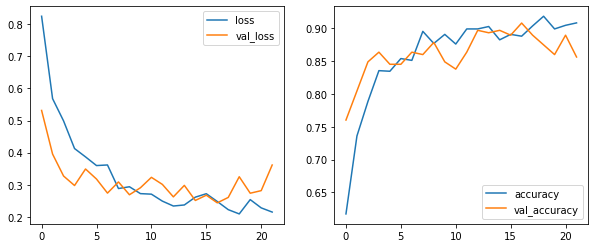

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [ ]:
y_true, y_pred = eval_model_on_test(scratch_resnet50)
predicted_labels = np.array([1 if p > 0.5 else 0 for p in y_pred])

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:20<00:00,  4.63it/s]


In [ ]:
print(classification_report(y_true, predicted_labels, 
                            target_names=classes))
pd.DataFrame(confusion_matrix(y_true, predicted_labels), 
             index=classes, columns=classes)

              precision    recall  f1-score   support

   no_damage       0.91      0.89      0.90      6333
      damage       0.89      0.90      0.90      5895

    accuracy                           0.90     12228
   macro avg       0.90      0.90      0.90     12228
weighted avg       0.90      0.90      0.90     12228



,no_damage,damage
no_damage,5656,677
damage,570,5325


In [ ]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


In [ ]:
fr_base_resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=IMG_SHAPE,
    weights='imagenet'
)

fr_base_resnet50.trainable = False

94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
fr_base_resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
fr_base_resnet50.trainable

False

In [ ]:
for layer in fr_base_resnet50.layers:
    print(layer.name, '->', layer.trainable)

input_5 -> False
conv1_pad -> False
conv1_conv -> False
conv1_bn -> False
conv1_relu -> False
pool1_pad -> False
pool1_pool -> False
conv2_block1_1_conv -> False
conv2_block1_1_bn -> False
conv2_block1_1_relu -> False
conv2_block1_2_conv -> False
conv2_block1_2_bn -> False
conv2_block1_2_relu -> False
conv2_block1_0_conv -> False
conv2_block1_3_conv -> False
conv2_block1_0_bn -> False
conv2_block1_3_bn -> False
conv2_block1_add -> False
conv2_block1_out -> False
conv2_block2_1_conv -> False
conv2_block2_1_bn -> False
conv2_block2_1_relu -> False
conv2_block2_2_conv -> False
conv2_block2_2_bn -> False
conv2_block2_2_relu -> False
conv2_block2_3_conv -> False
conv2_block2_3_bn -> False
conv2_block2_add -> False
conv2_block2_out -> False
conv2_block3_1_conv -> False
conv2_block3_1_bn -> False
conv2_block3_1_relu -> False
conv2_block3_2_conv -> False
conv2_block3_2_bn -> False
conv2_block3_2_relu -> False
conv2_block3_3_conv -> False
conv2_block3_3_bn -> False
conv2_block3_add -> False
con

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)

x = tf.keras.applications.resnet.preprocess_input(x)

x = fr_base_resnet50(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

frozen_resnet50 = tf.keras.Model(inputs, outputs)
frozen_resnet50.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_1 (Tenso [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)              

In [ ]:
for layer in frozen_resnet50.layers:
        print(layer.name, '->', layer.trainable)

input_6 -> True
sequential -> True
tf_op_layer_strided_slice_1 -> True
tf_op_layer_BiasAdd_1 -> True
resnet50 -> False
global_average_pooling2d_1 -> True
dense_9 -> True
dropout_6 -> True
dense_10 -> True
dropout_7 -> True
dense_11 -> True


In [ ]:
epochs = 100

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                     patience=5, 
                                     restore_best_weights=True)
]

frozen_resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history = frozen_resnet50.fit(
    train_ds, epochs=epochs, 
    callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
34/34 [==============================] - 2s 64ms/step - loss: 0.5968 - accuracy: 0.7010 - val_loss: 0.5325 - val_accuracy: 0.6827
Epoch 2/100
34/34 [==============================] - 1s 30ms/step - loss: 0.3829 - accuracy: 0.8224 - val_loss: 0.6144 - val_accuracy: 0.6125
Epoch 3/100
34/34 [==============================] - 1s 35ms/step - loss: 0.3156 - accuracy: 0.8657 - val_loss: 0.4788 - val_accuracy: 0.7417
Epoch 4/100
34/34 [==============================] - 1s 36ms/step - loss: 0.2926 - accuracy: 0.8767 - val_loss: 0.4436 - val_accuracy: 0.7638
Epoch 5/100
34/34 [==============================] - 1s 34ms/step - loss: 0.2866 - accuracy: 0.8868 - val_loss: 0.3386 - val_accuracy: 0.8745
Epoch 6/100
34/34 [==============================] - 1s 34ms/step - loss: 0.2767 - accuracy: 0.8795 - val_loss: 0.3033 - val_accuracy: 0.8967
Epoch 7/100
34/34 [==============================] - 1s 29ms/step - loss: 0.2615 - accuracy: 0.8988 - val_loss: 0.3126 - val_accuracy: 0.8782
Epoch 

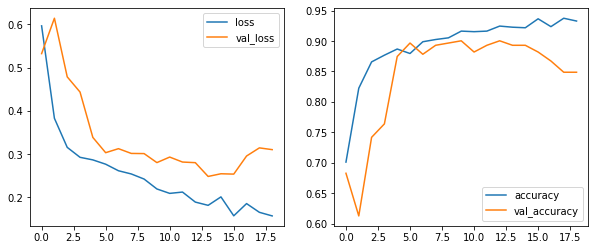

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [ ]:
y_true, y_pred = eval_model_on_test(frozen_resnet50)
predicted_labels = np.array([1 if p > 0.5 else 0 for p in y_pred])

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:20<00:00,  4.62it/s]


In [ ]:
print(classification_report(y_true, predicted_labels, 
                            target_names=classes))
pd.DataFrame(confusion_matrix(y_true, predicted_labels), 
             index=classes, columns=classes)

              precision    recall  f1-score   support

   no_damage       0.90      0.91      0.90      6333
      damage       0.90      0.89      0.89      5895

    accuracy                           0.90     12228
   macro avg       0.90      0.90      0.90     12228
weighted avg       0.90      0.90      0.90     12228



,no_damage,damage
no_damage,5753,580
damage,671,5224


In [ ]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


In [ ]:
ft_base_resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=IMG_SHAPE,
    weights='imagenet'
)

ft_base_resnet50.trainable = True

ft_base_resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
for layer in ft_base_resnet50.layers:
    print(layer.name, '->', layer.trainable)

input_7 -> True
conv1_pad -> True
conv1_conv -> True
conv1_bn -> True
conv1_relu -> True
pool1_pad -> True
pool1_pool -> True
conv2_block1_1_conv -> True
conv2_block1_1_bn -> True
conv2_block1_1_relu -> True
conv2_block1_2_conv -> True
conv2_block1_2_bn -> True
conv2_block1_2_relu -> True
conv2_block1_0_conv -> True
conv2_block1_3_conv -> True
conv2_block1_0_bn -> True
conv2_block1_3_bn -> True
conv2_block1_add -> True
conv2_block1_out -> True
conv2_block2_1_conv -> True
conv2_block2_1_bn -> True
conv2_block2_1_relu -> True
conv2_block2_2_conv -> True
conv2_block2_2_bn -> True
conv2_block2_2_relu -> True
conv2_block2_3_conv -> True
conv2_block2_3_bn -> True
conv2_block2_add -> True
conv2_block2_out -> True
conv2_block3_1_conv -> True
conv2_block3_1_bn -> True
conv2_block3_1_relu -> True
conv2_block3_2_conv -> True
conv2_block3_2_bn -> True
conv2_block3_2_relu -> True
conv2_block3_3_conv -> True
conv2_block3_3_bn -> True
conv2_block3_add -> True
conv2_block3_out -> True
conv3_block1_1_c

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)

x = tf.keras.applications.resnet.preprocess_input(x)

x = ft_base_resnet50(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

finetuned_resnet50 = tf.keras.Model(inputs, outputs)
finetuned_resnet50.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice_2  [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_2 (Tenso [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)              

In [ ]:
for layer in finetuned_resnet50.layers:
        print(layer.name, '->', layer.trainable)

input_8 -> True
sequential -> True
tf_op_layer_strided_slice_2 -> True
tf_op_layer_BiasAdd_2 -> True
resnet50 -> True
global_average_pooling2d_2 -> True
dense_12 -> True
dropout_8 -> True
dense_13 -> True
dropout_9 -> True
dense_14 -> True


In [ ]:
epochs = 100

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                     patience=5, 
                                     restore_best_weights=True)
]

finetuned_resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history = finetuned_resnet50.fit(
    train_ds, epochs=epochs, 
    callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
34/34 [==============================] - 3s 92ms/step - loss: 0.5310 - accuracy: 0.7415 - val_loss: 0.3679 - val_accuracy: 0.8598
Epoch 2/100
34/34 [==============================] - 2s 66ms/step - loss: 0.3020 - accuracy: 0.8795 - val_loss: 0.2544 - val_accuracy: 0.8967
Epoch 3/100
34/34 [==============================] - 2s 65ms/step - loss: 0.2194 - accuracy: 0.9043 - val_loss: 0.1876 - val_accuracy: 0.9151
Epoch 4/100
34/34 [==============================] - 2s 64ms/step - loss: 0.2197 - accuracy: 0.9154 - val_loss: 0.1801 - val_accuracy: 0.9151
Epoch 5/100
34/34 [==============================] - 2s 65ms/step - loss: 0.1621 - accuracy: 0.9328 - val_loss: 0.1539 - val_accuracy: 0.9188
Epoch 6/100
34/34 [==============================] - 2s 65ms/step - loss: 0.1488 - accuracy: 0.9347 - val_loss: 0.1395 - val_accuracy: 0.9262
Epoch 7/100
34/34 [==============================] - 2s 66ms/step - loss: 0.1275 - accuracy: 0.9466 - val_loss: 0.1382 - val_accuracy: 0.9262
Epoch 

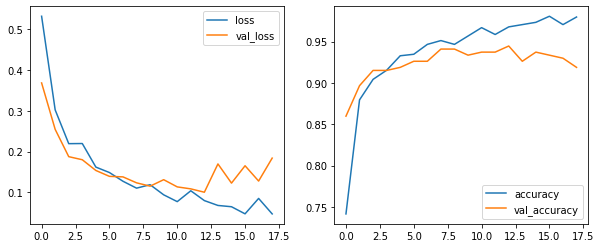

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [ ]:
y_true, y_pred = eval_model_on_test(finetuned_resnet50)
predicted_labels = np.array([1 if p > 0.5 else 0 for p in y_pred])

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:19<00:00,  4.92it/s]


In [ ]:
print(classification_report(y_true, predicted_labels, 
                            target_names=classes))
pd.DataFrame(confusion_matrix(y_true, predicted_labels), 
             index=classes, columns=classes)

              precision    recall  f1-score   support

   no_damage       0.94      0.95      0.95      6333
      damage       0.95      0.94      0.94      5895

    accuracy                           0.95     12228
   macro avg       0.95      0.95      0.95     12228
weighted avg       0.95      0.95      0.95     12228



,no_damage,damage
no_damage,6030,303
damage,361,5534


In [ ]:
def lr_function(epoch):
    start_lr = 1e-5; min_lr = 1e-5; max_lr = 1e-4
    rampup_epochs = 5; sustain_epochs = 0; exp_decay = .8
    
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, 
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) / rampup_epochs 
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) * 
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs) + min_lr)
        return lr

    return lr(epoch, start_lr, min_lr, max_lr, 
              rampup_epochs, sustain_epochs, exp_decay)

In [ ]:
import matplotlib.pyplot as plt


start lr: 1e-05 
end lr: 1.0004900066083662e-05


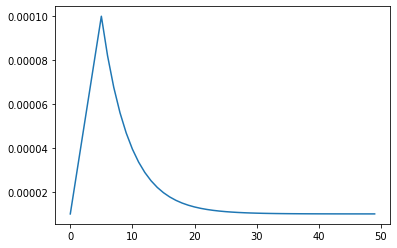

In [ ]:
rng = [i for i in range(50)]
y = [lr_function(x) for x in rng]
plt.plot(rng, [lr_function(x) for x in rng])
print('start lr:', y[0], '\nend lr:', y[-1])

In [ ]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


In [ ]:
exft_base_resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=IMG_SHAPE,
    weights='imagenet'
)
exft_base_resnet50.trainable = True


inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)

x = tf.keras.applications.resnet.preprocess_input(x)

x = exft_base_resnet50(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

lr_finetuned_resnet50 = tf.keras.Model(inputs, outputs)

In [ ]:
epochs = 100

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                     patience=5, 
                                     restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(lambda epoch: \
                                             lr_function(epoch), 
                                             verbose=True)
    
]

lr_finetuned_resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history = lr_finetuned_resnet50.fit(
    train_ds, epochs=epochs, callbacks=callbacks, 
    validation_data=val_ds,
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/100
34/34 [==============================] - 3s 92ms/step - loss: 0.5532 - accuracy: 0.7121 - val_loss: 0.5110 - val_accuracy: 0.7232

Epoch 00002: LearningRateScheduler reducing learning rate to 2.8000000000000003e-05.
Epoch 2/100
34/34 [==============================] - 2s 65ms/step - loss: 0.3030 - accuracy: 0.8795 - val_loss: 0.2184 - val_accuracy: 0.9114

Epoch 00003: LearningRateScheduler reducing learning rate to 4.6e-05.
Epoch 3/100
34/34 [==============================] - 2s 65ms/step - loss: 0.2541 - accuracy: 0.8933 - val_loss: 0.1591 - val_accuracy: 0.9336

Epoch 00004: LearningRateScheduler reducing learning rate to 6.4e-05.
Epoch 4/100
34/34 [==============================] - 2s 62ms/step - loss: 0.1628 - accuracy: 0.9347 - val_loss: 0.1937 - val_accuracy: 0.9041

Epoch 00005: LearningRateScheduler reducing learning rate to 8.2e-05.
Epoch 5/100
34/34 [==============================] - 2s 62ms/ste

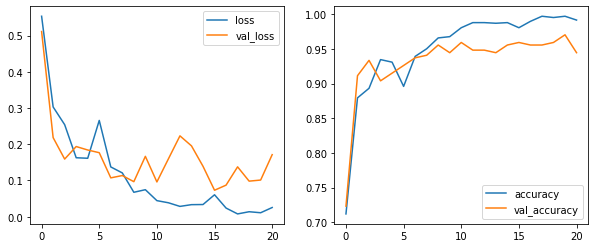

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [ ]:
y_true, y_pred = eval_model_on_test(lr_finetuned_resnet50)
predicted_labels = np.array([1 if p > 0.5 else 0 for p in y_pred])

Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

Found 12228 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 96/96 [00:19<00:00,  4.90it/s]


In [ ]:
print(classification_report(y_true, predicted_labels, 
                            target_names=classes))
pd.DataFrame(confusion_matrix(y_true, predicted_labels), 
             index=classes, columns=classes)

              precision    recall  f1-score   support

   no_damage       0.97      0.97      0.97      6333
      damage       0.97      0.97      0.97      5895

    accuracy                           0.97     12228
   macro avg       0.97      0.97      0.97     12228
weighted avg       0.97      0.97      0.97     12228



,no_damage,damage
no_damage,6135,198
damage,196,5699
